# Churn risk score prediction

### 1. import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.model_selection import RandomizedSearchCV

Using TensorFlow backend.


### 2. import train and test and clean data

In [170]:
df_train = pd.read_csv('./dataset/train.csv',na_values=['xxxxxxxx','Unknown','?',-999])
df_train.avg_frequency_login_days = abs(pd.to_numeric(df_train.avg_frequency_login_days,errors='coerce'))

l5 = np.where(df_train['churn_risk_score'] == -1)
df_train.drop(l5[0],inplace = True)

df_train.medium_of_operation = df_train.medium_of_operation.fillna(value='Both')
df_train.gender = df_train.gender.fillna('F')
df_train.avg_time_spent = abs(df_train.avg_time_spent)

df_test = pd.read_csv('./dataset/test.csv',na_values=['xxxxxxxx','Unknown','?',-999])
df_test.avg_frequency_login_days = abs(pd.to_numeric(df_test.avg_frequency_login_days,errors='coerce'))
df_test.medium_of_operation = df_test.medium_of_operation.fillna(value='Both')
df_test.gender = df_test.gender.fillna('F')
df_test.avg_time_spent = abs(df_test.avg_time_spent)

### 3. fill NaN and abs points in wallet and get features from joining year

In [171]:
cols_nan = ['region_category','joined_through_referral','preferred_offer_types','days_since_last_login','avg_frequency_login_days','points_in_wallet']
for col in cols_nan:
    if df_train[col].dtype == 'float64':
        df_train[col] = df_train[col].fillna(df_train[col].mean())
        df_test[col] = df_test[col].fillna(df_test[col].mean())
    else:
        df_train[col] = df_train[col].fillna(method='ffill') 
        df_test[col] = df_test[col].fillna(method='ffill')      

df_train.points_in_wallet = abs(df_train.points_in_wallet)   
df_test.points_in_wallet = abs(df_test.points_in_wallet)

df_train.joining_date = pd.to_datetime(df_train.joining_date)
df_train['joining_year'] = df_train.joining_date.dt.year
df_train['joining_month'] = df_train.joining_date.dt.month
df_train['joining_day'] = df_train.joining_date.dt.day
df_train.last_visit_time = pd.to_datetime(df_train.last_visit_time)
# total days = diff
df_train['diff'] = ((df_train['last_visit_time'] - df_train['joining_date']).apply(lambda x:str(x).split()[0])).astype('float64')

df_test.joining_date = pd.to_datetime(df_test.joining_date)
df_test['joining_year'] = df_test.joining_date.dt.year
df_test['joining_month'] = df_test.joining_date.dt.month
df_test['joining_day'] = df_test.joining_date.dt.day
df_test.last_visit_time = pd.to_datetime(df_test.last_visit_time)
df_test['diff'] = ((df_test['last_visit_time'] - df_test['joining_date']).apply(lambda x:str(x).split()[0])).astype('float64')

### 4. label encoding

In [172]:
le = preprocessing.LabelEncoder()

le_cols = ['gender','used_special_discount','offer_application_preference','past_complaint','joined_through_referral','membership_category','feedback']

for col in le_cols:
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col] = le.fit_transform(df_test[col])

### 5. one hot encoding

In [173]:
one_hot_cols = ['region_category','preferred_offer_types','medium_of_operation','internet_option','complaint_status']

df_train = pd.get_dummies(df_train,columns=one_hot_cols,drop_first=True)
df_test = pd.get_dummies(df_test,columns=one_hot_cols,drop_first=True)

### 6. drop columns and get x and y and x_test

In [174]:
cols_to_drop = ['customer_id','Name','security_no','referral_id','joining_date','last_visit_time']
df_train.drop(cols_to_drop,axis=1,inplace=True)
x = df_train.drop(['churn_risk_score'], axis=1)
y = df_train['churn_risk_score']
x_test = df_test.drop(cols_to_drop, axis=1)

### 7. SMOTE and separate train and cv from df_train (0.7,0.3)

In [142]:
oversampler = SMOTE()
x_ov, y_ov = oversampler.fit_resample(x,y)

x_train, x_cv, y_train, y_cv = train_test_split(x_ov,y_ov,train_size = 0.7,stratify = y_ov)

In [175]:
x_train, x_cv, y_train, y_cv = train_test_split(x,y,train_size = 0.7,stratify = y)

### 8. Models
#### 1. Random forest model

In [58]:
# train

rf_model = make_pipeline(RobustScaler(),RandomForestClassifier(class_weight='balanced'))
rf_model.fit(x_train,y_train)
y_pred = rf_model.predict(x_cv)

# cv
print(classification_report(y_cv,y_pred))
print(f1_score(y_cv,y_pred,average='micro'))

              precision    recall  f1-score   support

           1       0.85      0.84      0.85      3405
           2       0.83      0.87      0.85      3404
           3       0.87      0.89      0.88      3404
           4       0.68      0.58      0.63      3404
           5       0.73      0.79      0.76      3405

    accuracy                           0.79     17022
   macro avg       0.79      0.79      0.79     17022
weighted avg       0.79      0.79      0.79     17022

0.7939137586652566


In [59]:
rf_model.fit(x,y)
result = rf_model.predict(x_test)

In [70]:
rf_model.fit(x_ov,y_ov)
result = rf_model.predict(x_test)

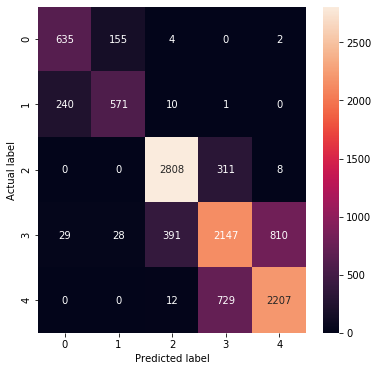

In [50]:
# random forest
fig = plt.figure(figsize=(6, 6))
ax= plt.subplot()
cm = confusion_matrix(y_true=y_cv,y_pred=y_pred)
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g')
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()

#### 2. Random forest with cross validation

In [ ]:
# train

rf_model = make_pipeline(RobustScaler(),RandomForestClassifier())

distributions = {
    'n_estimators': [100,150,200,250,300,400],
    'criterion': ['gini', 'entropy'],
    'max_depth': [10,40,60,100,150,200,260,300],
    'class_weight': ['balanced', 'balanced_subsample', None]
}
rf_model_cv = RandomizedSearchCV(rf_model.steps[1][1],distributions,n_jobs=-1,scoring='f1_macro')
rf_model_cv.fit(x_train,y_train)
print(rf_model_cv.best_params_,rf_model_cv.best_score_)

In [176]:
rf_model_1 = make_pipeline(RobustScaler(),RandomForestClassifier(n_estimators=250,max_depth=60,class_weight='balanced'))
rf_model_1.fit(x_train,y_train)
y_pred = rf_model_1.predict(x_cv)

# cv
print(classification_report(y_cv,y_pred))
print(f1_score(y_cv,y_pred,average='micro'))

              precision    recall  f1-score   support

           1       0.74      0.71      0.72       796
           2       0.73      0.72      0.72       822
           3       0.89      0.92      0.90      3127
           4       0.70      0.60      0.65      3056
           5       0.73      0.82      0.77      2948

    accuracy                           0.77     10749
   macro avg       0.76      0.75      0.75     10749
weighted avg       0.77      0.77      0.77     10749

0.7704902781654106


In [177]:
rf_model_1.fit(x,y)
result = rf_model_1.predict(x_test)

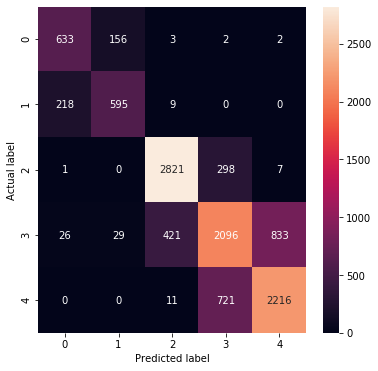

In [55]:
# rf model cv
fig = plt.figure(figsize=(6, 6))
ax= plt.subplot()
cm = confusion_matrix(y_true=y_cv,y_pred=y_pred)
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g')
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()

#### 3. Adaboost model

In [28]:
ada_model = make_pipeline(RobustScaler(),AdaBoostClassifier())
ada_model.fit(x_train,y_train)
y_pred = ada_model.predict(x_cv)

print(classification_report(y_cv,y_pred))
print(f1_score(y_cv,y_pred,average='micro'))

              precision    recall  f1-score   support

           1       0.53      0.15      0.23       796
           2       0.51      0.63      0.57       822
           3       0.71      0.66      0.68      3127
           4       0.28      0.19      0.23      3405
           5       0.46      0.72      0.56      2948

    accuracy                           0.49     11098
   macro avg       0.50      0.47      0.45     11098
weighted avg       0.48      0.49      0.47     11098

0.4935123445665886


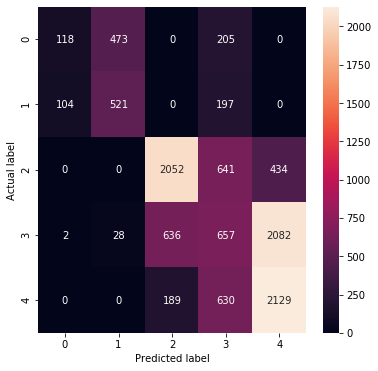

In [29]:
# adaboost
fig = plt.figure(figsize=(6, 6))
ax= plt.subplot()
cm = confusion_matrix(y_true=y_cv,y_pred=y_pred)
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g')
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()

#### 4. xgboost normal

In [30]:
xgb_model_n = make_pipeline(RobustScaler(),XGBClassifier())
xgb_model_n.fit(x_train,y_train)
y_pred = xgb_model_n.predict(x_cv)

print(classification_report(y_cv,y_pred))
print(f1_score(y_cv,y_pred,average='micro'))

              precision    recall  f1-score   support

           1       0.66      0.91      0.77       796
           2       0.85      0.59      0.70       822
           3       0.90      0.87      0.89      3127
           4       0.70      0.62      0.66      3405
           5       0.72      0.83      0.77      2948

    accuracy                           0.77     11098
   macro avg       0.77      0.77      0.76     11098
weighted avg       0.77      0.77      0.76     11098

0.7666246170481168


In [13]:
xgb_model_n.fit(x,y)
result = xgb_model_n.predict(x_test)

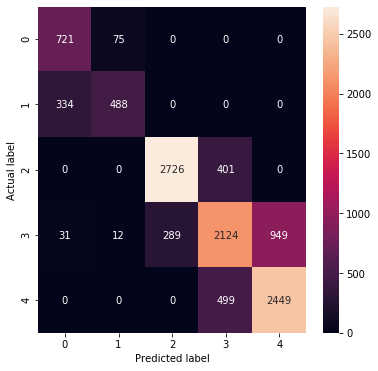

In [31]:
# xgboost
fig = plt.figure(figsize=(6, 6))
ax= plt.subplot()
cm = confusion_matrix(y_true=y_cv,y_pred=y_pred)
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g')
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()

#### 5. xgboost model with cv ( hyperparameter tuning by https://www.kaggle.com/sumanthhabib/hackerearth-customer-churn-risk-rate-prediction#EDA )

In [ ]:
xgc = XGBClassifier()

params={'learning_rate':[0.05,0.1,0.15,0.2],
       'max_depth':[3,4,5,6,8,10],
       'min_child_weight':[1,3,5,7],
       'gamma':[0.0,0.1,0.2,0.3,0.4,0.5],
       'colsample_bytree':[0.3,0.4,0.5,0.7]}
rsearch=RandomizedSearchCV(xgc,param_distributions=params,n_iter=100,cv=3,random_state=42,n_jobs=-1)
rsearch.fit(x,y)
rsearch.best_parameter_ 

In [166]:
xgb_model = make_pipeline(RobustScaler(),XGBClassifier(colsample_bytree=0.7, gamma=0.4, max_depth=4, min_child_weight=3, n_estimators=119, objective='multi:softprob'))
xgb_model.fit(x_train,y_train)
y_pred = xgb_model.predict(x_cv)

print(classification_report(y_cv,y_pred))
print(f1_score(y_cv,y_pred,average='macro'))

              precision    recall  f1-score   support

           1       0.72      0.89      0.80       796
           2       0.87      0.67      0.75       822
           3       0.91      0.92      0.92      3127
           4       0.76      0.55      0.64      3056
           5       0.71      0.91      0.79      2948

    accuracy                           0.79     10749
   macro avg       0.79      0.79      0.78     10749
weighted avg       0.80      0.79      0.78     10749

0.779964951957206


In [167]:
xgb_model.fit(x,y)
result = xgb_model.predict(x_test)

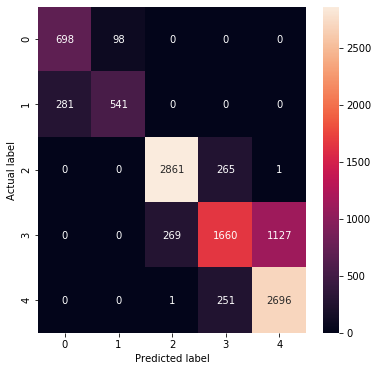

In [157]:
# xgb with cv
fig = plt.figure(figsize=(6, 6))
ax= plt.subplot()
cm = confusion_matrix(y_true=y_cv,y_pred=y_pred)
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g')
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()

#### 6. xgbrf model

In [41]:
xgbrf_model = make_pipeline(RobustScaler(),XGBRFClassifier())
xgbrf_model.fit(x_train,y_train)
y_pred = xgbrf_model.predict(x_cv)

print(classification_report(y_cv,y_pred))
print(f1_score(y_cv,y_pred,average='micro'))

              precision    recall  f1-score   support

           1       0.71      0.66      0.68      3405
           2       0.69      0.77      0.73      3404
           3       0.79      0.81      0.80      3404
           4       0.59      0.60      0.60      3404
           5       0.70      0.64      0.67      3405

    accuracy                           0.70     17022
   macro avg       0.70      0.70      0.70     17022
weighted avg       0.70      0.70      0.70     17022

0.6962754082951474


In [42]:
xgbrf_model.fit(x,y)
result = xgbrf_model.predict(x_test)

## 9. Submit

In [178]:
submission = pd.DataFrame({
    'customer_id': df_test['customer_id'],
    'churn_risk_score': result,
})

print(submission['churn_risk_score'].value_counts())

submission.to_csv('sub55.csv', index=False)

5    6115
3    5866
4    4959
1    1626
2    1353
Name: churn_risk_score, dtype: int64
